In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import kaggle
import zipfile
from glob import glob

In [2]:
!kaggle datasets download -d bme3412/iphone-on-ebay-webscrape-daily-20212022

iphone-on-ebay-webscrape-daily-20212022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zipname = 'iphone-on-ebay-webscrape-daily-20212022.zip'
target_directory = 'C:/Users/loren/Desktop/dap/dap/DailyData'
with zipfile.ZipFile(zipname, 'r') as file:
    file.extractall(path=target_directory)

In [4]:
csvs = glob("DailyData/*.csv")
data = [pd.read_csv(file) for file in csvs]
rawdata = pd.concat(data, ignore_index=True)
rawdata['Date'] = pd.to_datetime(rawdata['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

In [5]:
rawdata['Model'] = rawdata['Product'].str.extract(r'Apple iPhone\s?([^\s/-]+)', expand=False, flags=re.IGNORECASE)
rawdata = rawdata.dropna(subset=['Model'])

rawdata['Storage'] = rawdata['Product'].str.extract(r'(\d+GB)', expand=False)
rawdata = rawdata.dropna(subset=['Storage'])
rawdata['Storage'] = rawdata['Storage'].str.rstrip('GB').astype(int)

In [6]:
rawdata = rawdata.rename(columns={'Unnamed: 0': 'Vendor ID'})

In [7]:
rawdata['Price'] = rawdata['Price'].replace('[\\$,]', '', regex=True)

def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

rawdata['Price'] = rawdata['Price'].apply(lambda x: np.mean([convert_to_float(i) for i in x.split(' to ')] if ' to ' in x else convert_to_float(x) if x else np.nan))

In [8]:
model_mapping = {
    'Thirteen': '13',
    'Xr': 'XR',
    'Xs': 'XS',
    '4s': '4S',
    '5s,': '5S',
    '12,': '12',
    '5s': '5S',
    '5c': '5C',
    '8,': '8',
    '6s': '6S',
    '6s,': '6S',
    '7,': '7',
    's': '8'
}

rawdata['Model'] = rawdata['Model'].replace(model_mapping)

In [9]:
print(rawdata.groupby('Vendor ID')['Product'].nunique())

Vendor ID
0         3
1         3
2         2
3         3
4         3
         ..
555926    1
555929    1
555933    1
555950    1
570202    1
Name: Product, Length: 2201, dtype: int64


In [10]:
print(rawdata.groupby('Model')['Price'].mean().sort_values())

Model
SE2      0.990000
4       17.594404
3Gs     20.053433
5       21.556443
4S      27.130883
5C      28.342197
3GS     36.559716
5S      39.482449
6       76.814935
6S      89.629960
7      133.779734
8+     178.988544
SE     189.043559
8      196.105596
7+     197.678679
1st    213.676636
XR     269.854641
X      279.904431
XS     355.925765
11     453.545367
12     643.805243
13     877.057199
Name: Price, dtype: float64


In [11]:
print(rawdata['Model'].unique())

['7' '11' '8' 'X' '12' 'XR' 'XS' 'SE' '7+' '5S' '6S' '13' '6' '8+' '4S'
 '5C' '3Gs' '4' '1st' '5' '3GS' 'SE2']


In [12]:
# Convert the 'Date' column to datetime format
rawdata['Date'] = pd.to_datetime(rawdata['Date'], format='%Y-%m-%d')

# Calculate the duration for each listing
rawdata['Duration'] = rawdata.groupby('Vendor ID')['Date'].transform(lambda x: (x.max() - x.min()).days)

# Create a new column for the year
rawdata['Year'] = rawdata['Date'].dt.year

# Define smaller price ranges with steps of 50
price_ranges = [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250), (250, 300), (300, 350), (350, 400), (400, 450), (450, 500), (500, 550), (550, 600), (600, 650), (650, 700), (700, 750), (750, 800), (800, 850), (850, 900), (900, 950), (950, 1000), (1000, float('inf'))]

# Create a new column for price range
rawdata['Price Range'] = pd.cut(rawdata['Price'], bins=[x[0] for x in price_ranges] + [float('inf')], labels=[f"{x[0]}-{x[1]}" for x in price_ranges])

# Group by phone model, year, and price range, and calculate the mean duration
result = rawdata.groupby(['Model', 'Year', 'Price Range'])['Duration'].mean()

# Display the result
print(result)


Model  Year  Price Range
11     2021  0-50           267.000000
             50-100         275.294314
             100-150        173.149068
             150-200        245.266129
             200-250        267.000000
                               ...    
XS     2022  800-850               NaN
             850-900               NaN
             900-950               NaN
             950-1000              NaN
             1000-inf              NaN
Name: Duration, Length: 924, dtype: float64


C:\Users\loren\AppData\Local\Temp\ipykernel_23532\3785881548.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = rawdata.groupby(['Model', 'Year', 'Price Range'])['Duration'].mean()


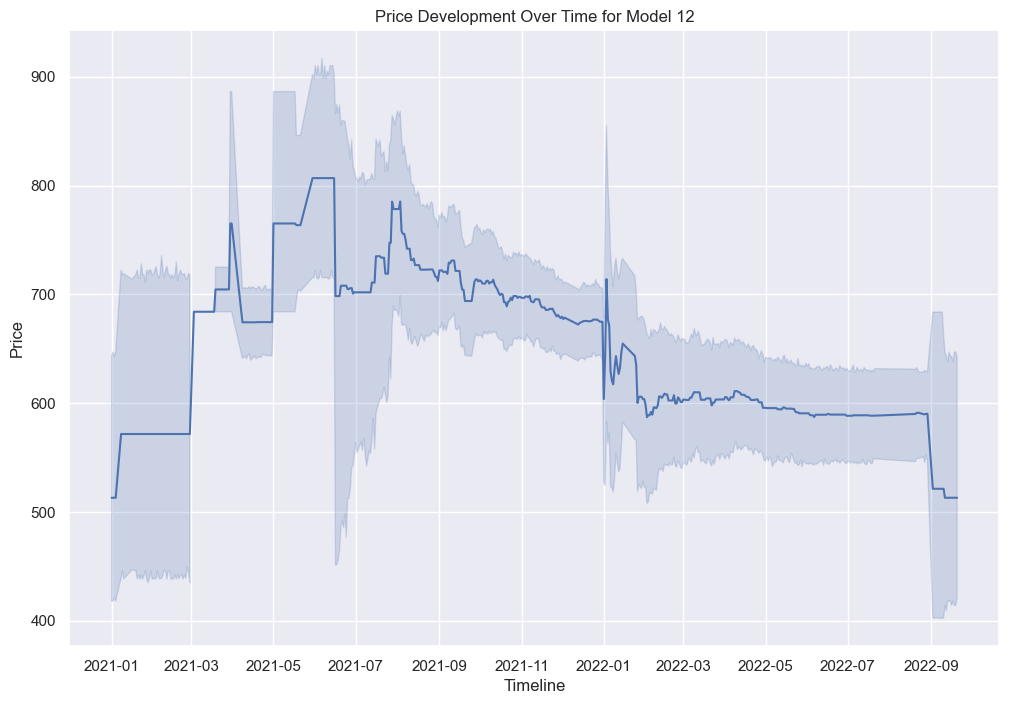

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="darkgrid")

# Filter data for the model '12'
model_12_data = rawdata[rawdata['Model'] == '12']

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Price', data=model_12_data)

# Set plot labels and title
plt.xlabel('Timeline')
plt.ylabel('Price')
plt.title('Price Development Over Time for Model 12')

# Show the plot
plt.show()


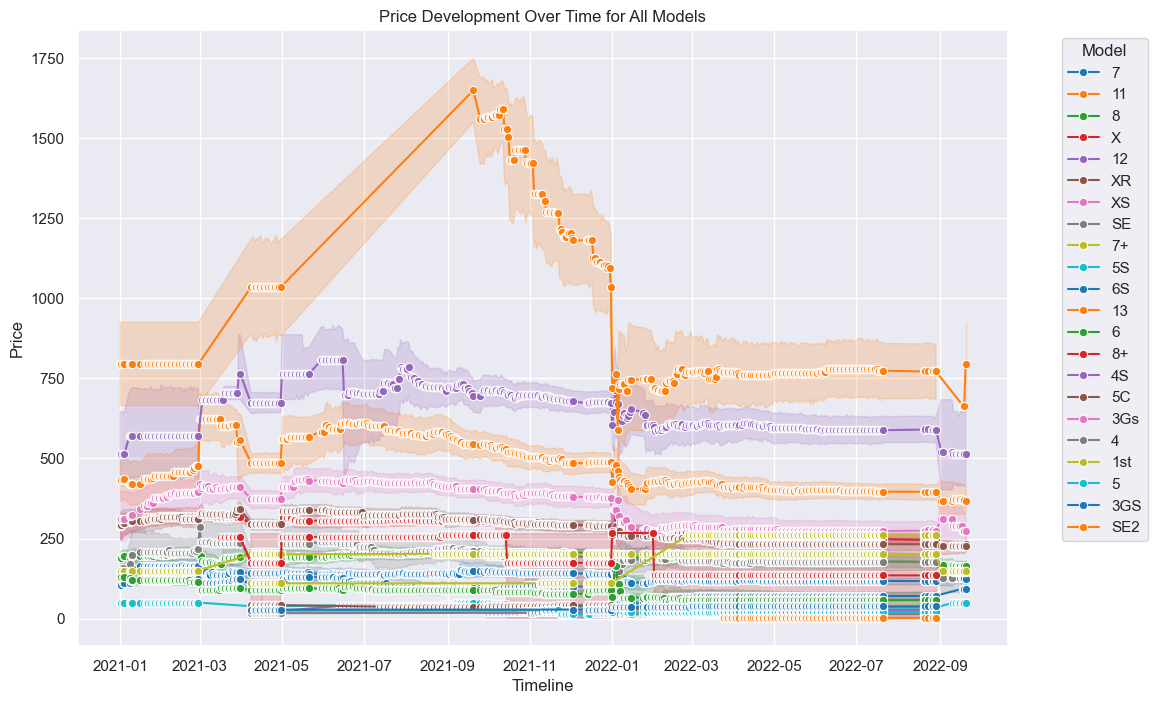

: 

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="darkgrid")

# Create a line plot for each model on one graph
plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Price', hue='Model', data=rawdata, palette='tab10', legend='full', marker='o')

# Set plot labels and title
plt.xlabel('Timeline')
plt.ylabel('Price')
plt.title('Price Development Over Time for All Models')

# Show the legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
